# Chat Intents

## Universal Sentence Encoder

In [1]:
import numpy as np
import pandas as pd

pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)
pd.set_option("max_colwidth", 400)

import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer

In [2]:
import tensorflow as tf
import tensorflow_hub as hub

In [3]:
import umap
from sklearn.cluster import DBSCAN
import hdbscan

In [4]:
module_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
model = hub.load(module_url)

print(f"module {module_url} loaded")

def embed(input):
    return model(input)

module https://tfhub.dev/google/universal-sentence-encoder/4 loaded


In [5]:
data_sample = pd.read_csv('data/processed/data_sample.csv')
data_sample.head()

,Unnamed: 0,text,category,cleaned_text
0,1024,I'm worried my card might be lost in the mail? How long does it usually take to arrive?,card_delivery_estimate,im worried card might lost mail long usually take arrive
1,9405,I got charged a fee that shouldn't be there from my cash,cash_withdrawal_charge,got charged fee shouldnt cash
2,9368,Do you charge for making a withdrawal? I took some money out of my account earlier and I was charged for this.,cash_withdrawal_charge,charge making withdrawal took money account earlier charged
3,3414,Is there an issue with my account? I don't see a cheque deposit that I made yesterday. Please assist.,balance_not_updated_after_cheque_or_cash_deposit,issue account dont see cheque deposit made yesterday please assist
4,7402,Are there ways for other people to send me money?,receiving_money,way people send money


In [7]:
embed([data_sample.loc[0, 'text']])

<tf.Tensor: shape=(1, 512), dtype=float32, numpy=
array([[-0.06579605, -0.06647699,  0.00171667,  0.02178268,  0.01742516,
         0.04219121,  0.02537893, -0.04058336,  0.03160436, -0.08325108,
        -0.02934882, -0.08077615, -0.03173568, -0.00771644,  0.01482838,
         0.08487448,  0.0729969 ,  0.06724288, -0.02711436,  0.02483022,
         0.00095537,  0.05671262, -0.00828924,  0.05223312, -0.00672474,
        -0.03601372,  0.00277846, -0.0046194 , -0.08389046,  0.01052436,
         0.01104345,  0.02776407,  0.02455765,  0.07385753,  0.03697617,
         0.03937263, -0.07424648, -0.03812434, -0.02038852, -0.06478386,
        -0.01576349, -0.00706339, -0.02068471,  0.01186877,  0.04984849,
        -0.03528761, -0.05001155, -0.04611909,  0.04342199, -0.03479601,
        -0.02357922,  0.10001004,  0.02362901, -0.04974519, -0.00488419,
        -0.02349371, -0.08911229, -0.04806096, -0.02530827, -0.00910803,
        -0.07358308, -0.00862287,  0.0558563 , -0.07700697, -0.00480305,
 

In [8]:
all_intents = list(data_sample['text'])
intents_embeddings = embed(all_intents)
intents_embeddings.shape

TensorShape([1000, 512])

In [11]:
umap_embeddings = umap.UMAP(n_neighbors = 4, 
                            n_components = 3, 
                            metric = 'cosine').fit_transform(intents_embeddings)

cluster = hdbscan.HDBSCAN(min_cluster_size=5, 
                          metric='euclidean', 
                          cluster_selection_method='eom').fit(umap_embeddings)

intents_df = pd.DataFrame(all_intents, columns=['message'])
intents_df['topic'] = cluster.labels_

In [12]:
all_messages_per_topic = intents_df.groupby(['topic'], as_index=False).agg({'message': ' '.join})

In [30]:
def c_tf_idf(documents, m, ngram_range=(1,1)):
    count = CountVectorizer(ngram_range = ngram_range, stop_words = 'english').fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)
    
    return tf_idf, count

def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=10):
    words = count.get_feature_names()
    labels = list(docs_per_topic.topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    top_n_words_only = {label: [words[j] for j in indices[i]][::-1] for i, label in enumerate(labels)}
    
    return top_n_words, top_n_words_only

def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['topic']).message.count()
                   .reset_index()
                   .rename({'message':'size'}, axis='columns')
                   .sort_values('size', ascending=False))
    return topic_sizes

In [31]:
tf_idf, count = c_tf_idf(all_messages_per_topic.message.values, m = len(data_sample))

In [32]:
top_n_words, top_n_words_only = extract_top_n_words_per_topic(tf_idf, count, all_messages_per_topic, n=10)

In [33]:
top_n_words[0]

[('countries', 1.8056455799132056),
 ('operate', 0.7311303645202578),
 ('know', 0.408678596999646),
 ('offices', 0.40633854582247864),
 ('provide', 0.34171429354788396),
 ('services', 0.34171429354788396),
 ('offer', 0.3247918186977792),
 ('service', 0.29187324293687195),
 ('available', 0.2770900412732893),
 ('like', 0.20247172801073005)]

In [34]:
top_n_words[-1]

[('card', 0.08273773988154884),
 ('charged', 0.07809421357639766),
 ('account', 0.07251042874580997),
 ('fee', 0.07100974039282246),
 ('money', 0.06861795114242418),
 ('got', 0.06039997346116736),
 ('extra', 0.059051332390230735),
 ('cash', 0.05252098671238286),
 ('fees', 0.04609996161362716),
 ('atm', 0.045269067319766314)]

In [35]:
df_keywords = pd.DataFrame()
df_keywords['topic'] = top_n_words_only.keys()
df_keywords['keywords'] = top_n_words_only.values()

In [36]:
extract_topic_sizes(intents_df).merge(df_keywords, how='left', on='topic')

,topic,size,keywords
0,-1,160,"(card, charged, account, fee, money, got, extra, cash, fees, atm)"
1,41,60,"(payment, cancelled, declined, pending, card, did, reverted, didn, tell, merchant)"
2,30,35,"(long, does, pending, transfer, wait, expect, time, europe, money, transferred)"
3,23,26,"(european, bank, sepa, fees, fee, cost, charged, charges, receiving, charge)"
4,11,26,"(virtual, disposable, card, cards, work, explain, heard, using, use, order)"
5,1,25,"(identity, prove, verification, identification, verify, verified, need, documentation, required, check)"
6,52,24,"(atm, atms, use, accept, locations, cheque, card, used, withdraw, cheques)"
7,3,23,"(funds, source, money, know, came, wallet, available, come, flow, comes)"
8,36,21,"(use, want, option, topping, card, times, fixing, methods, maximum, supported)"
9,14,21,"(pin, new, card, china, number, isn, want, select, located, overseas)"


In [38]:
intents_df[intents_df['topic']==1]

,message,topic
82,"Can I use my account now, even though my identity verification has not gone through yet?",1
91,I'm not able to verify my identity.,1
101,Can you tell me what I need for identity validation?,1
104,What documentation do you accept for the identity check?,1
214,What is the purpose of requiring my identification?,1
261,Why is my identity not verified?,1
339,How can I prove I am me?,1
388,I have trouble proving my identity.,1
397,Can I use my account although the identity verification has not been accepted yet?,1
412,Why hasn't the app verified my identity?,1


In [37]:
intents_df[intents_df['message'].str.contains('card')]

,message,topic
0,I'm worried my card might be lost in the mail? How long does it usually take to arrive?,30
7,What do I do if I still have not received my new card?,61
8,Is there anywhere I can't use my card?,37
15,Please let me know how to place an order for a virtual card,11
17,Do I have to pick a creditcard brand?,10
24,My card doesn't seem to work.,50
27,"I am overseas in China, can I get a replacement card?",14
30,Where do I find my code to verify my top-up card?,6
33,How do I transfer funds directly from my credit card?,56
35,Can you tell me why my credit card was declined while trying to top-up?,41


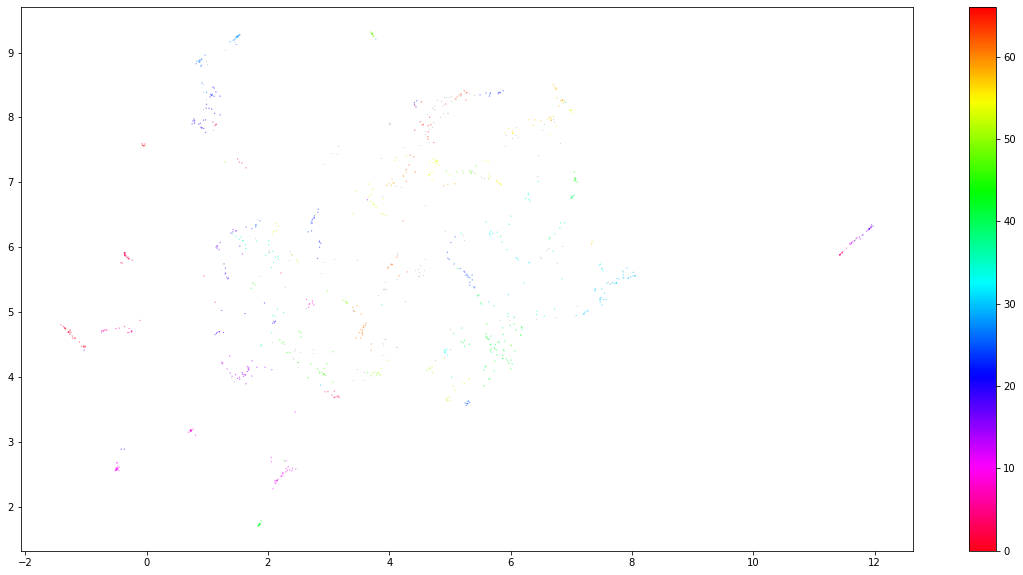

In [41]:
umap_data = umap.UMAP(n_neighbors=15, 
                      n_components=2, 
                      min_dist = 0.0, 
                      metric='cosine').fit_transform(intents_embeddings)

result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = cluster.labels_

#visualizing clusters
fig, ax = plt.subplots(figsize=(20, 10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color = '#BDBDBD', s=0.05)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=0.05, cmap='hsv_r')
plt.colorbar()